In [4]:
%load_ext autoreload
%autoreload 2
from matricesRalas import MatrizRala
from funciones_utiles import norma
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Matrices papers
import csv

N = 0
citas_recibidas = {}
cantidad_citados = []
# citas es un dict que para todo paper me dice quienes lo citaron (lista de ids)
# y me dice a cuantos cita en la posición 0

with open('papers/papers.csv', newline='') as csvfile:
    papers = csv.DictReader(csvfile)
    for row in papers:
        N+= 1
        cantidad_citados.append(0)


with open('papers/citas.csv', newline='') as csvfile:
    quotations = csv.DictReader(csvfile)
    for row in quotations:
        citador = int(row["from"])
        citado = int(row["to"])

        if citado not in citas_recibidas.keys():
          citas_recibidas[citado] = [citador]
        else:
          citas_recibidas[citado].append(citador) 
        
        cantidad_citados[citador] += 1
        
# Armamos W
W = MatrizRala(N,N)
for i in citas_recibidas.keys():
  for j in citas_recibidas[i]:
    W[i, j] = 1

# Armamos D
D = MatrizRala(N,N)
for i in range(N):
  if (cantidad_citados[i] != 0):
    D[i,i] = 1/cantidad_citados[i]

unos = MatrizRala(N,1)
for i in range(N):
    unos[i,0]=1

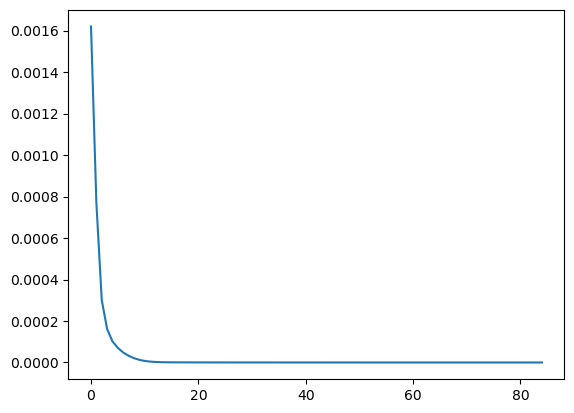

85
2.3816555363964602e-07


In [15]:
# Método iterativo
import time

# Recordemos W, D y d
epsilon = 1e-6 # Arbitrario

d=0.85

p_t = MatrizRala(N,1)
for i in range(N):
    p_t[i,0] = 1/N

diferencias = []

i = 0

while i == 0 or diferencias[i-1] > epsilon:
    if (i != 0):
        p_t = p_next
    
    inicio = time.time()
    
    p_next = unos * ((1 - d) / N) + d * W @ D @ p_t

    fin = time.time()

    diferencias.append(norma(p_next-p_t))
    

    i += 1


xs = [x for x in range(len(diferencias))]

plt.plot(xs, diferencias)
plt.show()
# Make sure to close the plt object once done
plt.close()


print(i)
print(p_next[0,0])

In [6]:
# SE HALLA EL TOP 10 DE PAPERS SEGUN LA CANTIDAD DE CITADOS

diezPopulares: Dict[int, int] = dict() # La clave es el paper y el valor es la cantidad de citas que recibe
for paper, lista_citas in citas_recibidas.items():
    if len(diezPopulares) < 10:
        diezPopulares[paper] = len(lista_citas)
    else:
        citasMenosPopular: int = 1e10
        paperMenosPopular: int = None
        for clave, valor in diezPopulares.items():
            if valor < citasMenosPopular:
                paperMenosPopular = clave
                citasMenosPopular = valor

        if len(lista_citas) > citasMenosPopular:
            diezPopulares.pop(paperMenosPopular)
            diezPopulares[paper] = len(lista_citas)

In [38]:
diezImpacto: Dict[int, float] = dict()
for nro_paper, fila in p_next.filas.items():
    valorFinal: float = fila.raiz.valor[1]
    if len(diezImpacto) < 10:
        diezImpacto[nro_paper] = valorFinal
    else:
        menosImpacto: int = 1e10
        paperMenosImpacto: int = None
        for clave, valor in diezImpacto.items():
            if valor < menosImpacto:
                paperMenosImpacto = clave
                menosImpacto = valor

        if valorFinal > menosImpacto:
            diezImpacto.pop(paperMenosImpacto)
            diezImpacto[nro_paper] = valorFinal

In [39]:

print("Busco los nombres de los dos top 10 encontrados...")

nombresAlgoritmo: List[Tuple[str, int, float]] = []
nombresCitasRecibidas: List[Tuple[str, int, int]] = []
with open('papers/papers.csv', newline='', encoding="utf-8") as csvfile:
    quotations = csv.DictReader(csvfile)
    for row in quotations:
        if int(row["id"]) in diezPopulares.keys():
            nombresCitasRecibidas.append((row["titulo"], int(row["id"]), diezPopulares[int(row["id"])]))
        if int(row["id"]) in diezImpacto.keys():
            nombresAlgoritmo.append((row["titulo"], int(row["id"]), diezImpacto[int(row["id"])]))

nombresAlgoritmo.sort(key=lambda x : x[2], reverse=True)

print("Papers con mayor impacto")
for nombre in nombresAlgoritmo: 
    print(f"Paper: {nombre[0]}, id: {nombre[1]}, proba:{nombre[2]}")

nombresCitasRecibidas.sort(key=lambda x : x[2], reverse=True)

print("\n")
print("Papers con más citas")
for nombre in nombresCitasRecibidas: 
    print(f"Paper: {nombre[0]}, id: {nombre[1]}, citas recibidas:{nombre[2]}")


Busco los nombres de los dos top 10 encontrados...
Papers con mayor impacto
Paper: The art of computer programming, volume 2 (3rd ed.): seminumerical algorithms, id: 81323, proba:0.0001090987659164113
Paper: A method for obtaining digital signatures and public-key cryptosystems, id: 327827, proba:0.00010885138969481051
Paper: The art of computer programming, volume 1 (3rd ed.): fundamental algorithms, id: 79620, proba:0.0001067656639101375
Paper: A relational model of data for large shared data banks, id: 326368, proba:0.00010480290317944726
Paper: Recovery semantics for a DB/DC system, id: 547167, proba:0.00010365818833926049
Paper: Recovery scenario for a DB/DC system, id: 552437, proba:0.00010214186810240287
Paper: Programming semantics for multiprogrammed computations, id: 322720, proba:6.487399029953157e-05
Paper: Principles of interactive computer graphics (2nd ed.), id: 153803, proba:6.257019374152439e-05
Paper: Report on the algorithmic language ALGOL 60, id: 328020, proba:5.75